# Demo: Text-To-Image Synthesis (CUB-200-2011)

In [1]:
import torch

import matplotlib.pyplot as plt

from utils.utils import pad_onehot_transpose

from datasets.utils import Tokenizer

from models.dcgan import Generator
from models.text_encoder import CNNRNNEncoder

In [2]:
from cub.config import (
    WEIGHTS_TEXT_ENCODER,
    WEIGHTS_GENERATOR,
)

In [3]:
# Tokenizer
tokenizer = Tokenizer()
vocab_size = len(tokenizer)

cnn_dim = 512
emb_dim = 1024
average = True

# Text encoder
text_encoder = CNNRNNEncoder(vocab_size, cnn_dim, emb_dim, average)
text_encoder.load_state_dict(torch.load(WEIGHTS_TEXT_ENCODER, weights_only=True, map_location="cpu"))

<All keys matched successfully>

In [4]:
# Generator
nz = 100
nt = 128
ngf = 128

generator = Generator(nz, nt, emb_dim, ngf)
generator.load_state_dict(torch.load(WEIGHTS_GENERATOR, weights_only=True, map_location="cpu"))

<All keys matched successfully>

In [5]:
queries = [
    "the bill is short and pointed, the body is a dark gray back with lighter breast",
    "a bird with a medium-sized black and orange bill, orange tarsi.",
    "this bird is red.",
    "this bird is yellow.",
    "this bird is blue.",
]

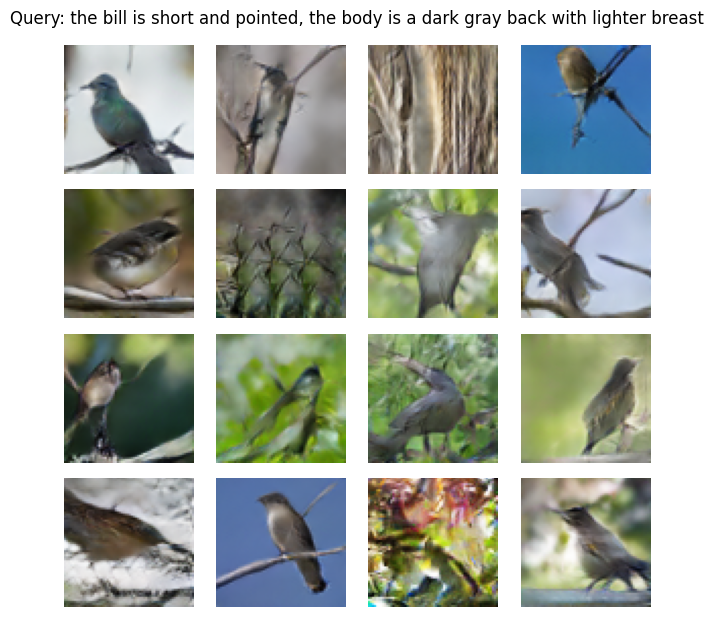

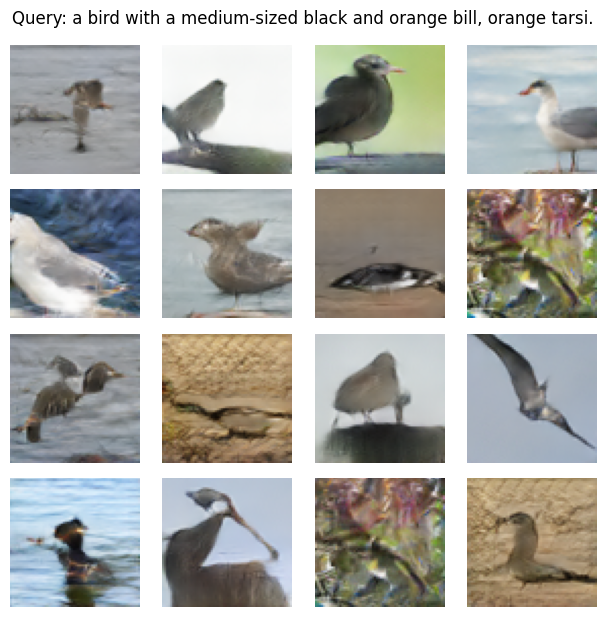

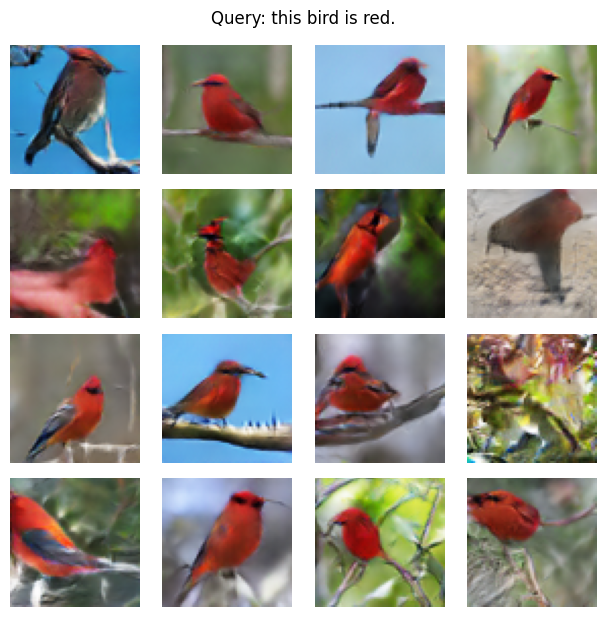

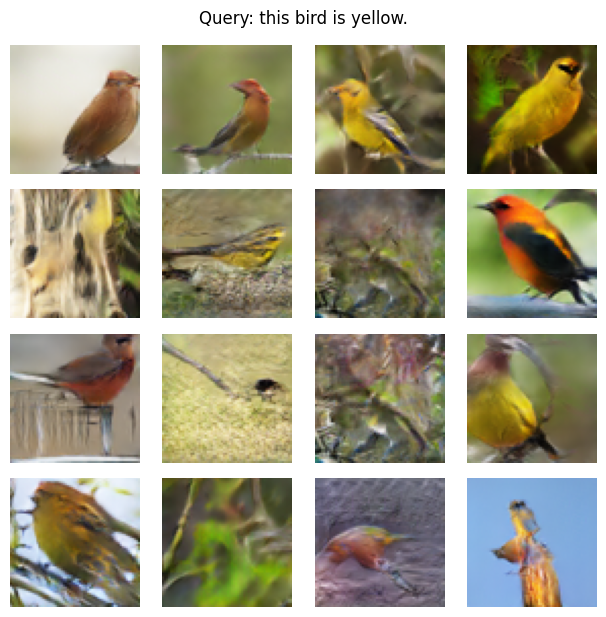

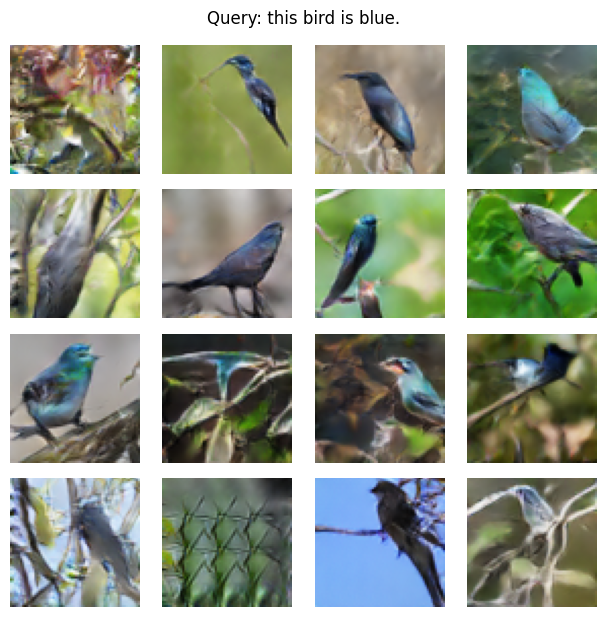

In [6]:
text_encoder.eval()
generator.eval()


N_ROWS = 4
N_COLS = 4
DPI = 100
H, W = 64, 64
FIGSIZE = (N_COLS * DPI / W, N_ROWS * DPI / H)


for query in queries:
    fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
    ax = ax.flatten()

    # Tokenization
    text_str = query
    text_tok = tokenizer(text_str)
    text_tok = pad_onehot_transpose(text_tok, 0, 201, 70).unsqueeze(0)

    # Encode text 
    text_emb = text_encoder(text_tok)

    fig.suptitle(f"Query: {text_str}") 
    for j in range(N_ROWS * N_COLS):

        noise = torch.randn((1, 100, 1, 1))

        fake_img = generator(noise, text_emb)
        fake_img = fake_img.squeeze(0)  # [3, 64, 64]

        fake_img = fake_img.detach().cpu().numpy()
        fake_img = fake_img.transpose(1, 2, 0)
        fake_img = ((fake_img+1)/2).clip(0, 1)

        ax[j].imshow(fake_img)
        ax[j].axis("off")
    plt.tight_layout() 
    plt.show()